# Complex Shifted Laplace Preconditioner for Krylov Subspace Methods for the Discretized Helmholtz Equation on the Unit Interval

Discretizes the indefinite Helmholtz equation $\frac{d^2 \, u}{dx^2} + k^2 \, u= f$ on the unit bar domain $\Omega=(0,1)$ supplied with various boundary conditions and various source terms. The finite difference method on a uniform mesh is employed. The linear system is solved using CSLP as preconditioner for a Krylov subspace method. 

## Import Packages

In [1]:
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using Preconditioners
using IncompleteLU
using BenchmarkTools 
using Plots
using LaTeXStrings
using BenchmarkTools 

## Step (1/3): One-Dimensional Finite Difference Code

This first examples uses the homogeneous Dirichlet boundary condition in both the left end-point and the right end-point. The source function $f(x)$ is chosen as point-source.

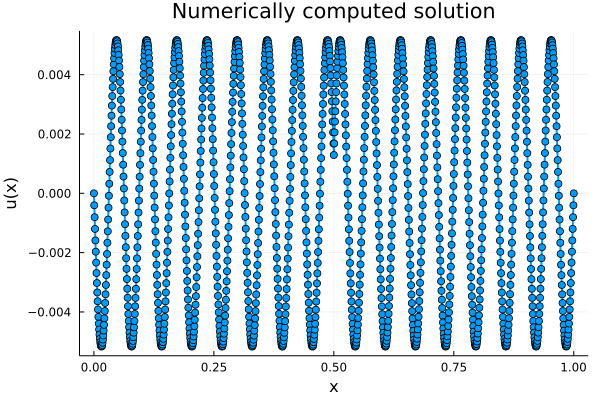

In [13]:
#..set the wave number (in [1/m]) and its square (in [1/m^2]) 
kwav = 100; 
kwav2 = kwav*kwav; 

#..set the number of grid points per wavelength (gpw)
gpw = 10;  

#..set the mesh width h to ensure a given number of grid points per wavelength (kwav h = gpw) (requires more work)
h = gpw/kwav; 

#..compute the number of element. Augment number of elements in case that number of elements is odd 
N = round(Int,1/h)
if isodd(N) N+=1 end 
h=1/(128*N); h2 = h*h; 

#..construct the 1D mesh
x = Vector(0:h:1); 
Np1 = length(x)

#..construct the source function 
f=zeros(size(x));
f[Np1÷2+1]=1/h; 
if false 
  plot(x,f)
end 

#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(e[2:end], (-2+h2*kwav2)*e, e[2:end]); 
A = (1/h2)*A; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=0;      A[end,end] = 1;      f[end] = 0;  
    
#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

## Step (2/3): ILU preconditioning of tridiagonal matrices

For tridiagonal system LU == ILU.

In [26]:
#..set the wave number (in [1/m]) and its square (in [1/m^2]) 
kwav = 100; 
kwav2 = kwav*kwav; 

#..set the number of grid points per wavelength (gpw)
gpw = 10;  

#..set the mesh width h to ensure a given number of grid points per wavelength (kwav h = gpw) (requires more work)
h = gpw/kwav; 

#..compute the number of element. Augment number of elements in case that number of elements is odd 
N = round(Int,1/h)
if isodd(N) N+=1 end 
h=1/(128*N); h2 = h*h; 

#..construct the 1D mesh
x = Vector(0:h:1); 
Np1 = length(x)

#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(e[2:end], (-2+h2*kwav2)*e, e[2:end]); 
A = (1/h2)*A; 

A = sparse(A);

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=0;      A[end,end] = 1;      f[end] = 0; 

fact = ilu(A, τ = 0.001)

IncompleteLU.ILUFactorization{Float64, Int64}(
⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄, 
⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠳⣄

## Step (3/3): Solve Linear System Using CSLP Preconditioned Krylov Subspace Solvers

Allows to switch between LU and ILU for M. 

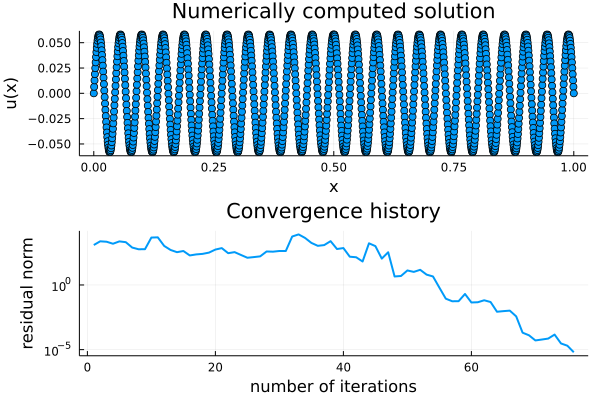

In [38]:
#..set the wave number (in [1/m]) and its square (in [1/m^2]) 
kwav = 100; 
kwav2 = kwav*kwav; 

#..set the number of grid points per wavelength (gpw)
gpw = 10;  

#..set the mesh width h to ensure a given number of grid points per wavelength (kwav h = gpw) (requires more work)
h = gpw/kwav; 

#..compute the number of element. Augment number of elements in case that number of elements is odd 
N = round(Int,1/h)
if isodd(N) N+=1 end 
h=1/(128*N); h2 = h*h; 

#..construct the 1D mesh
x = Vector(0:h:1); 
Np1 = length(x)

#..construct the source function 
f=zeros(size(x));
f[Np1÷2+1]=1/h; 
if false 
  plot(x,f)
end 

#..set the complex shift (beta2) in the CSLP preconditioner 
beta2=1.; 

#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(e[2:end], (-2+h2*kwav2)*e, e[2:end]); 
A = Tridiagonal(e[2:end], (-2+h2*kwav2)*e, e[2:end])+h2*kwav2*Diagonal(e); 
A = (1/h2)*A; 
A = sparse(A); 
M = Tridiagonal(e[2:end], (-2+h2*kwav2)*e, e[2:end])+(beta2*1im)*h2*kwav2*Diagonal(e); 
M = Tridiagonal(e[2:end], (-2+h2*kwav2)*e, e[2:end]); 
M = (1/h2)*M;
M = sparse(M);

#..handle the boundary conditions in the matrix, preconditioner and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=0;      A[end,end] = 1;      f[end] = 0;  
M[1,1] = 1;          M[1,2] = 0;         
M[end,end-1]=0;      M[end,end] = 1;    
    
#..solve the linear system
p = lu(M);
#LU = ilu(A, τ = 0.1)
u, ch = idrs(A, f, Pl=p, maxiter=100000, log=true)

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

p2=plot(ch[:resnorm], yaxis=:log,lw=2,legend=false)
xlabel!("number of iterations") 
ylabel!("residual norm")
title!("Convergence history")

plot(p1,p2, layout = (2,1))

## References

1. The Helmholtz equation is explained here [wiki](https://en.wikipedia.org/wiki/Helmholtz_equation). 